In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl 
%matplotlib inline
import seaborn as sns
sns.set()
sns.set(font_scale=1.5)

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn import metrics
from sklearn import set_config 
from sklearn.utils import estimator_html_repr 
from IPython.core.display import display, HTML 
from category_encoders import TargetEncoder

import xgboost as xgb
from xgboost import XGBClassifier

import lightgbm as lgb
from lightgbm import LGBMClassifier

import pickle

import sys

if not sys.warnoptions:
    import warnings
    warnings.filterwarnings(action='ignore', category=UserWarning)
    
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [2]:
# Read data
df = pd.read_pickle('../data/interim/train_clean_roll_up.pickle')

In [3]:
df.head()

,ProductName,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,...,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,Census_OSBranch_release_encoded,AvSigVersion_encoded,AppVersion_encoded,EngineVersion_encoded,OsVer_encoded
0,win8defender,7.0,0,53447.0,1.0,1.0,1,29,128035.0,18.0,...,0,0,0,10.0,0,rs4_release,273,18,15100,10.0
1,win8defender,7.0,0,53447.0,1.0,1.0,1,93,1482.0,18.0,...,0,0,0,8.0,0,rs4_release,Other,13,14600,10.0
2,win8defender,7.0,0,53447.0,1.0,1.0,1,86,153579.0,18.0,...,0,0,0,3.0,0,rs4_release,273,18,15100,10.0
3,win8defender,7.0,0,53447.0,1.0,1.0,1,88,20710.0,NaN,...,0,0,0,3.0,1,rs4_release,273,18,15100,10.0
4,win8defender,7.0,0,53447.0,1.0,1.0,1,18,37376.0,NaN,...,0,0,0,1.0,1,rs4_release,273,18,15100,10.0


In [4]:
df.shape

(8921478, 71)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8921478 entries, 0 to 8921482
Data columns (total 71 columns):
 #   Column                                             Dtype   
---  ------                                             -----   
 0   ProductName                                        category
 1   RtpStateBitfield                                   category
 2   IsSxsPassiveMode                                   Int64   
 3   AVProductStatesIdentifier                          category
 4   AVProductsInstalled                                category
 5   AVProductsEnabled                                  category
 6   HasTpm                                             Int64   
 7   CountryIdentifier                                  category
 8   CityIdentifier                                     category
 9   OrganizationIdentifier                             category
 10  GeoNameIdentifier                                  category
 11  LocaleEnglishNameIdentifier          

In [6]:
# Store features in X and target in y
X = df.loc[:, df.columns != 'HasDetections']
y = df['HasDetections']

In [7]:
# Separate train and test data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 10)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7137182, 70)
(1784296, 70)
(7137182,)
(1784296,)


In [8]:
y_train.mean(), y_test.mean()

(0.49977540155204114, 0.4998621304985271)

In [9]:
y_train.dtype, y_test.dtype

(Int64Dtype(), Int64Dtype())

In [10]:
# Adjust target dtype
y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [11]:
# Separate features by data type: categorical, ID, numerical and binary
id_col = ['AVProductStatesIdentifier',
          'CountryIdentifier',
          'CityIdentifier',
          'OrganizationIdentifier',
          'GeoNameIdentifier',
          'LocaleEnglishNameIdentifier',
          'IeVerIdentifier',
          'Census_OEMNameIdentifier',
          'Census_OEMModelIdentifier',
          'Census_ProcessorManufacturerIdentifier',
          'Census_ProcessorModelIdentifier',
          'Census_OSInstallLanguageIdentifier',
          'Census_OSUILocaleIdentifier',
          'Census_FirmwareManufacturerIdentifier',
          'Census_FirmwareVersionIdentifier',
          'Wdft_RegionIdentifier']
cat_col = [col for col in X_train.select_dtypes('category').columns.tolist() 
           if col not in id_col]
binary_col = X_train.select_dtypes('Int64').columns.tolist()
num_col = [col for col in X_train.columns 
           if col not in cat_col
           if col not in id_col
           if col not in binary_col]

len(cat_col), len(id_col), len(binary_col), len(num_col) 

(33, 16, 14, 7)

In [12]:
len(cat_col) + len(id_col) + len(binary_col) + len(num_col)

70

In [15]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer()

# Preprocessing for binary data
binary_transformer = SimpleImputer()

# Preprocessing for categorical data encoded as numerical ID's
id_transformer = Pipeline(steps=[
    ('encoding', TargetEncoder())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_col),
        ('bin', binary_transformer, binary_col),
        ('id', id_transformer, id_col),
        ('cat', categorical_transformer, cat_col)
    ])

In [16]:
# Define feature selection strategy
var_filter = VarianceThreshold()
# selector = SelectKBest(mutual_info_classif)
selector = SelectKBest(f_classif)

## XGBoost Model

In [17]:
# Define model
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', 
                            eval_metric='logloss', 
                            use_label_encoder =False,
                            n_jobs=-1,
                            verbosity=0)

In [18]:
#  Make pipeline with preprocessing, feature selection and model
pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                               ('filter', var_filter),
                               ('selector', selector),
                               ('classifier', xgb_clf)
                              ])

In [19]:
set_config(display='diagram')
display(HTML(estimator_html_repr(pipeline_xgb)))

In [20]:
# Parameters for Randomized search
parameters ={'selector__k': [100, 200, 300],
             'preprocessor__num__strategy': ['mean', 'median'],
             'preprocessor__bin__strategy': ['most_frequent'],
             'preprocessor__id__encoding__smoothing': [0.0, 10.0, 100.0],
             'preprocessor__cat__imputer__strategy': ['most_frequent', 'constant'],
             'classifier__learning_rate': [0.1, 0.3, 0.5],
             'classifier__gamma' : [0, 2, 5, 10],
             'classifier__max_depth': range(1, 15, 2),
             'classifier__subsample': [0.5, 0.8, 1],
             'classifier__min_child_weight': [0.5, 1, 3],
             'classifier__n_estimators': [200, 300, 400]}

# Randomized search
search_xgb = RandomizedSearchCV(estimator=pipeline_xgb, 
                                param_distributions=parameters,
                                n_iter=15,
                                cv=3,
                                scoring='roc_auc',
                                return_train_score=True,
                                random_state=42,
                                verbose=3)

# Preprocessing of training data, fit model 
search_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV 1/3] END classifier__gamma=0, classifier__learning_rate=0.5, classifier__max_depth=5, classifier__min_child_weight=0.5, classifier__n_estimators=400, classifier__subsample=0.5, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=constant, preprocessor__id__encoding__smoothing=10.0, preprocessor__num__strategy=median, selector__k=100;, score=(train=0.749, test=0.714) total time=34.7min
[CV 2/3] END classifier__gamma=0, classifier__learning_rate=0.5, classifier__max_depth=5, classifier__min_child_weight=0.5, classifier__n_estimators=400, classifier__subsample=0.5, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=constant, preprocessor__id__encoding__smoothing=10.0, preprocessor__num__strategy=median, selector__k=100;, score=(train=0.749, test=0.715) total time=34.7min
[CV 3/3] END classifier__gamma=0, classifier__learning_rate=0.5, classifier__max_depth=5, classifie

[CV 3/3] END classifier__gamma=5, classifier__learning_rate=0.1, classifier__max_depth=7, classifier__min_child_weight=1, classifier__n_estimators=200, classifier__subsample=0.8, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=constant, preprocessor__id__encoding__smoothing=100.0, preprocessor__num__strategy=mean, selector__k=200;, score=(train=0.743, test=0.713) total time=28.5min
[CV 1/3] END classifier__gamma=5, classifier__learning_rate=0.5, classifier__max_depth=11, classifier__min_child_weight=3, classifier__n_estimators=400, classifier__subsample=1, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=constant, preprocessor__id__encoding__smoothing=100.0, preprocessor__num__strategy=median, selector__k=300;, score=(train=0.829, test=0.712) total time=89.8min
[CV 2/3] END classifier__gamma=5, classifier__learning_rate=0.5, classifier__max_depth=11, classifier__min_child_weight=3, classifier__n_estimators=400, classifier__

[CV 2/3] END classifier__gamma=5, classifier__learning_rate=0.5, classifier__max_depth=11, classifier__min_child_weight=1, classifier__n_estimators=300, classifier__subsample=0.5, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__id__encoding__smoothing=10.0, preprocessor__num__strategy=median, selector__k=300;, score=(train=0.801, test=0.701) total time=77.6min
[CV 3/3] END classifier__gamma=5, classifier__learning_rate=0.5, classifier__max_depth=11, classifier__min_child_weight=1, classifier__n_estimators=300, classifier__subsample=0.5, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__id__encoding__smoothing=10.0, preprocessor__num__strategy=median, selector__k=300;, score=(train=0.799, test=0.701) total time=72.0min
[CV 1/3] END classifier__gamma=10, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__min_child_weight=3, classifier__n_estimators=200,

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               SimpleImputer(),
                                                                               ['Census_ProcessorCoreCount',
                                                                                'Census_PrimaryDiskTotalCapacity',
                                                                                'Census_SystemVolumeTotalCapacity',
                                                                                'Census_TotalPhysicalRAM',
                                                                                'Census_InternalPrimaryDiagonalDisplaySizeInInches',
                                                                                'Census_InternalPrimaryDisplayResolutionHorizontal',
                                                                                '...
                                        'classifier__subsample': [0.5, 0.8, 1],
                                        'preprocessor__bin__strategy': ['most_frequent'],
                                        'preprocessor__cat__imputer__strategy': ['most_frequent',
                                                                                 'constant'],
                                        'preprocessor__id__encoding__smoothing': [0.0,
                                                                                  10.0,
                                                                                  100.0],
                                        'preprocessor__num__strategy': ['mean',
                                                                        'median'],
                                        'selector__k': [100, 200, 300]},
                   random_state=42, return_train_score=True, scoring='roc_auc',
                   verbose=3)

In [21]:
# Optimized model
opt_xgb_clf = search_xgb.best_estimator_
search_xgb.best_params_

{'selector__k': 100,
 'preprocessor__num__strategy': 'median',
 'preprocessor__id__encoding__smoothing': 10.0,
 'preprocessor__cat__imputer__strategy': 'most_frequent',
 'preprocessor__bin__strategy': 'most_frequent',
 'classifier__subsample': 0.8,
 'classifier__n_estimators': 300,
 'classifier__min_child_weight': 0.5,
 'classifier__max_depth': 13,
 'classifier__learning_rate': 0.1,
 'classifier__gamma': 10}

In [22]:
# Predictions
y_pred_train_xgb = opt_xgb_clf.predict(X_train)
y_pred_test_xgb = opt_xgb_clf.predict(X_test)
y_pred_proba_train_xgb = opt_xgb_clf.predict_proba(X_train)
y_pred_proba_test_xgb = opt_xgb_clf.predict_proba(X_test)

In [23]:
# ROC_AUC evaluation
roc_auc_train_xgb = round(roc_auc_score(y_train, y_pred_proba_train_xgb[:, 1]), 2)
roc_auc_test_xgb = round(roc_auc_score(y_test, y_pred_proba_test_xgb[:, 1]), 2)
print('Train Set roc auc:', roc_auc_train_xgb) 
print('Test Set roc auc:', roc_auc_test_xgb)

Train Set roc auc: 0.76
Test Set roc auc: 0.72


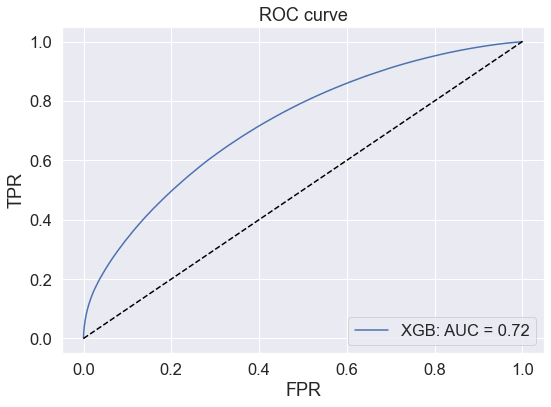

In [24]:
# plot ROC_AUC
fpr_xgb, tpr_xgb, thresholds_xgb = metrics.roc_curve(y_test, y_pred_proba_test_xgb[:,1])

plt.figure(figsize=(8,6))
plt.plot(fpr_xgb, tpr_xgb, label='XGB: AUC = {}'.format(roc_auc_test_xgb))
plt.plot([0,1], [0,1], '--', color = 'black')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc=4)
plt.title('ROC curve')
plt.tight_layout()

In [25]:
# classification report
print(classification_report(y_test, y_pred_test_xgb))

              precision    recall  f1-score   support

           0       0.66      0.66      0.66    892394
           1       0.66      0.66      0.66    891902

    accuracy                           0.66   1784296
   macro avg       0.66      0.66      0.66   1784296
weighted avg       0.66      0.66      0.66   1784296



### XGB Feature importance

In [26]:
search_xgb.best_params_

{'selector__k': 100,
 'preprocessor__num__strategy': 'median',
 'preprocessor__id__encoding__smoothing': 10.0,
 'preprocessor__cat__imputer__strategy': 'most_frequent',
 'preprocessor__bin__strategy': 'most_frequent',
 'classifier__subsample': 0.8,
 'classifier__n_estimators': 300,
 'classifier__min_child_weight': 0.5,
 'classifier__max_depth': 13,
 'classifier__learning_rate': 0.1,
 'classifier__gamma': 10}

In [27]:
# Preprocess data with best parameters
numerical_transformer_rev = SimpleImputer(strategy=search_xgb.best_params_['preprocessor__num__strategy'])
binary_transformer_rev = SimpleImputer(strategy=search_xgb.best_params_['preprocessor__bin__strategy'])
id_transformer_rev = Pipeline(steps=[
    ('encoding', TargetEncoder(search_xgb.best_params_['preprocessor__id__encoding__smoothing']))
])
categorical_transformer_rev = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy=search_xgb.best_params_['preprocessor__cat__imputer__strategy'])),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_rev = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_rev, num_col),
        ('bin', binary_transformer_rev, binary_col),
        ('id', id_transformer_rev, id_col),
        ('cat', categorical_transformer_rev, cat_col)
    ])

pipeline_rev = Pipeline(steps=[('preprocessor', preprocessor_rev)])

In [28]:
# Features selected
chosen_feat = opt_xgb_clf.named_steps['selector'].get_support()
list(enumerate(chosen_feat))

[(0, True),
 (1, True),
 (2, False),
 (3, True),
 (4, True),
 (5, True),
 (6, False),
 (7, True),
 (8, False),
 (9, False),
 (10, False),
 (11, False),
 (12, True),
 (13, False),
 (14, False),
 (15, False),
 (16, True),
 (17, True),
 (18, True),
 (19, True),
 (20, True),
 (21, True),
 (22, True),
 (23, True),
 (24, True),
 (25, True),
 (26, True),
 (27, True),
 (28, True),
 (29, True),
 (30, False),
 (31, True),
 (32, True),
 (33, True),
 (34, True),
 (35, True),
 (36, True),
 (37, False),
 (38, False),
 (39, False),
 (40, False),
 (41, False),
 (42, False),
 (43, True),
 (44, False),
 (45, False),
 (46, False),
 (47, True),
 (48, True),
 (49, True),
 (50, False),
 (51, True),
 (52, True),
 (53, True),
 (54, False),
 (55, False),
 (56, False),
 (57, False),
 (58, True),
 (59, True),
 (60, True),
 (61, False),
 (62, False),
 (63, False),
 (64, False),
 (65, False),
 (66, False),
 (67, False),
 (68, False),
 (69, True),
 (70, True),
 (71, False),
 (72, False),
 (73, True),
 (74, False),


In [30]:
# Preprocess data and get feature importances
X_values = preprocessor_rev.fit_transform(X_train, y_train)
onehot_col = pipeline_rev.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names(input_features=cat_col)
columns_tot = num_col + binary_col + id_col + onehot_col.tolist()
columns_tot = [feat for bool_, feat in zip(chosen_feat, columns_tot) if bool_]

feature_importance = pd.Series(data=opt_xgb_clf.named_steps['classifier'].feature_importances_,
                               index = np.array(columns_tot))

In [31]:
feature_importance = feature_importance.sort_values(ascending=False)

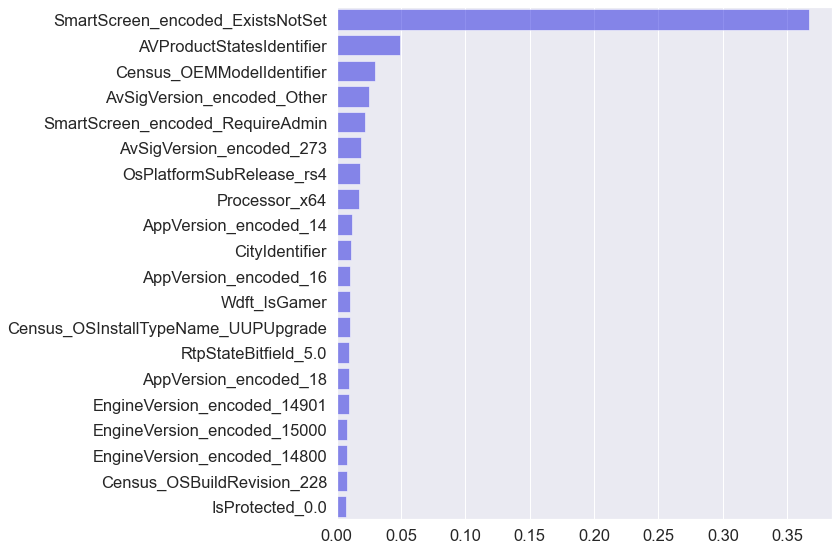

In [32]:
# Plot Feature Importances
plt.figure(figsize=(12, 8))
sns.barplot(y=feature_importance.index[:20], 
            x=feature_importance.values[:20],
            color='blue',
            alpha=.5,
            orient='h')
plt.tight_layout()

## Random Forest Model 

In [33]:
# Define model
rf_clf = RandomForestClassifier(random_state = 42, n_jobs=-1)

In [34]:
#  Make pipeline with preprocessing, feature selection and model
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('filter', var_filter),
                              ('selector', selector),
                              ('classifier', rf_clf)
                              ])

In [36]:
# Randomized search
n_estimators = [100, 200, 300]
max_features = ['auto', 'sqrt']
max_depth = range(1, 20, 3)
min_samples_split = [3, 5, 7, 10, 15, 20, 25]
min_samples_leaf = [2, 3, 5, 7, 10, 15, 20, 25]

parameters = {'selector__k': [100, 200, 300],
              'preprocessor__num__strategy': ['median'],
              'preprocessor__bin__strategy': ['most_frequent'],
              'preprocessor__id__encoding__smoothing': [0.0, 10.0, 100.0],
              'preprocessor__cat__imputer__strategy': ['most_frequent', 'constant'],
              'classifier__n_estimators': n_estimators,
              'classifier__max_features' : max_features,
              'classifier__max_depth': max_depth,
              'classifier__min_samples_split': min_samples_split,
              'classifier__min_samples_leaf': min_samples_leaf
}

search_rf = RandomizedSearchCV(estimator=pipeline_rf, 
                               param_distributions=parameters,
                               n_iter=15,
                               cv=3,
                               scoring='roc_auc',
                               return_train_score=True,
                               verbose=3)

# Preprocessing of training data, fit model 
search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV 1/3] END classifier__max_depth=19, classifier__max_features=auto, classifier__min_samples_leaf=5, classifier__min_samples_split=15, classifier__n_estimators=100, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__id__encoding__smoothing=0.0, preprocessor__num__strategy=median, selector__k=200;, score=(train=0.752, test=0.710) total time=69.8min
[CV 2/3] END classifier__max_depth=19, classifier__max_features=auto, classifier__min_samples_leaf=5, classifier__min_samples_split=15, classifier__n_estimators=100, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__id__encoding__smoothing=0.0, preprocessor__num__strategy=median, selector__k=200;, score=(train=0.752, test=0.710) total time=69.3min
[CV 3/3] END classifier__max_depth=19, classifier__max_features=auto, classifier__min_samples_leaf=5, classifier__min_sam

[CV 3/3] END classifier__max_depth=7, classifier__max_features=auto, classifier__min_samples_leaf=5, classifier__min_samples_split=15, classifier__n_estimators=300, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=constant, preprocessor__id__encoding__smoothing=0.0, preprocessor__num__strategy=median, selector__k=200;, score=(train=0.705, test=0.694) total time=18.7min
[CV 1/3] END classifier__max_depth=10, classifier__max_features=auto, classifier__min_samples_leaf=5, classifier__min_samples_split=20, classifier__n_estimators=300, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__id__encoding__smoothing=0.0, preprocessor__num__strategy=median, selector__k=100;, score=(train=0.714, test=0.698) total time=40.9min
[CV 2/3] END classifier__max_depth=10, classifier__max_features=auto, classifier__min_samples_leaf=5, classifier__min_samples_split=20, classifier__n_estimators=300, preprocessor__bin__str

[CV 3/3] END classifier__max_depth=16, classifier__max_features=sqrt, classifier__min_samples_leaf=5, classifier__min_samples_split=25, classifier__n_estimators=300, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=constant, preprocessor__id__encoding__smoothing=0.0, preprocessor__num__strategy=median, selector__k=200;, score=(train=0.736, test=0.708) total time=129.2min
[CV 1/3] END classifier__max_depth=10, classifier__max_features=sqrt, classifier__min_samples_leaf=25, classifier__min_samples_split=5, classifier__n_estimators=100, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=constant, preprocessor__id__encoding__smoothing=0.0, preprocessor__num__strategy=median, selector__k=300;, score=(train=0.711, test=0.697) total time=13.9min
[CV 2/3] END classifier__max_depth=10, classifier__max_features=sqrt, classifier__min_samples_leaf=25, classifier__min_samples_split=5, classifier__n_estimators=100, preprocessor__bin__strate

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               SimpleImputer(),
                                                                               ['Census_ProcessorCoreCount',
                                                                                'Census_PrimaryDiskTotalCapacity',
                                                                                'Census_SystemVolumeTotalCapacity',
                                                                                'Census_TotalPhysicalRAM',
                                                                                'Census_InternalPrimaryDiagonalDisplaySizeInInches',
                                                                                'Census_InternalPrimaryDisplayResolutionHorizontal',
                                                                                '...
                                                                          7, 10,
                                                                          15,
                                                                          20,
                                                                          25],
                                        'classifier__n_estimators': [100, 200,
                                                                     300],
                                        'preprocessor__bin__strategy': ['most_frequent'],
                                        'preprocessor__cat__imputer__strategy': ['most_frequent',
                                                                                 'constant'],
                                        'preprocessor__id__encoding__smoothing': [0.0,
                                                                                  10.0,
                                                                                  100.0],
                                        'preprocessor__num__strategy': ['median'],
                                        'selector__k': [100, 200, 300]},
                   return_train_score=True, scoring='roc_auc', verbose=3)

In [37]:
# optimized model
opt_rf_clf = search_rf.best_estimator_
search_rf.best_params_

{'selector__k': 300,
 'preprocessor__num__strategy': 'median',
 'preprocessor__id__encoding__smoothing': 100.0,
 'preprocessor__cat__imputer__strategy': 'most_frequent',
 'preprocessor__bin__strategy': 'most_frequent',
 'classifier__n_estimators': 200,
 'classifier__min_samples_split': 3,
 'classifier__min_samples_leaf': 25,
 'classifier__max_features': 'sqrt',
 'classifier__max_depth': 19}

In [38]:
# Predictions
y_pred_train_rf = opt_rf_clf.predict(X_train)
y_pred_test_rf = opt_rf_clf.predict(X_test)
y_pred_proba_train_rf = opt_rf_clf.predict_proba(X_train)
y_pred_proba_test_rf = opt_rf_clf.predict_proba(X_test)

In [39]:
# ROC_AUC evaluation
roc_auc_train_rf = round(roc_auc_score(y_train, y_pred_proba_train_rf[:, 1]), 2)
roc_auc_test_rf = round(roc_auc_score(y_test, y_pred_proba_test_rf[:, 1]), 2)
print('Train Set roc auc:', roc_auc_train_rf) 
print('Test Set roc auc:', roc_auc_test_rf)

Train Set roc auc: 0.73
Test Set roc auc: 0.71


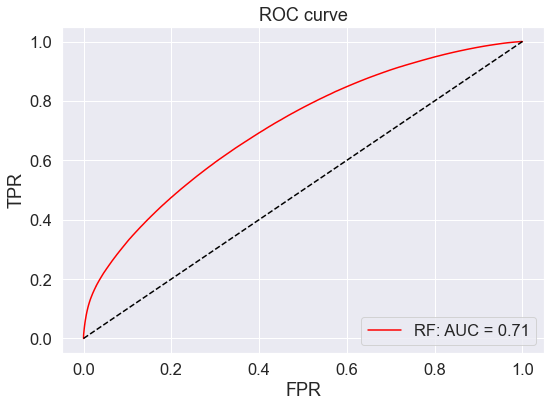

In [40]:
# plot ROC_AUC
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, y_pred_proba_test_rf[:,1])

plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, color='red', label='RF: AUC = {}'.format(roc_auc_test_rf))
plt.plot([0,1], [0,1], '--', color = 'black')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc=4)
plt.title('ROC curve')
plt.tight_layout()

In [41]:
# classification report
print(classification_report(y_test, y_pred_test_rf))

              precision    recall  f1-score   support

           0       0.65      0.64      0.64    892394
           1       0.64      0.66      0.65    891902

    accuracy                           0.65   1784296
   macro avg       0.65      0.65      0.65   1784296
weighted avg       0.65      0.65      0.65   1784296



### RF Feature importance

In [42]:
search_rf.best_params_

{'selector__k': 300,
 'preprocessor__num__strategy': 'median',
 'preprocessor__id__encoding__smoothing': 100.0,
 'preprocessor__cat__imputer__strategy': 'most_frequent',
 'preprocessor__bin__strategy': 'most_frequent',
 'classifier__n_estimators': 200,
 'classifier__min_samples_split': 3,
 'classifier__min_samples_leaf': 25,
 'classifier__max_features': 'sqrt',
 'classifier__max_depth': 19}

In [44]:
# Preprocess data with best parameters
numerical_transformer_rev = SimpleImputer(strategy=search_rf.best_params_['preprocessor__num__strategy'])
binary_transformer_rev = SimpleImputer(strategy=search_rf.best_params_['preprocessor__bin__strategy'])
id_transformer_rev = Pipeline(steps=[
    ('encoding', TargetEncoder(search_rf.best_params_['preprocessor__id__encoding__smoothing']))
])
categorical_transformer_rev = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy=search_rf.best_params_['preprocessor__cat__imputer__strategy'])),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_rev = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_rev, num_col),
        ('bin', binary_transformer_rev, binary_col),
        ('id', id_transformer_rev, id_col),
        ('cat', categorical_transformer_rev, cat_col)
    ])

pipeline_rev = Pipeline(steps=[('preprocessor', preprocessor_rev)])

In [45]:
# Features selected
chosen_feat = opt_rf_clf.named_steps['selector'].get_support()
list(enumerate(chosen_feat))

[(0, True),
 (1, True),
 (2, True),
 (3, True),
 (4, True),
 (5, True),
 (6, True),
 (7, True),
 (8, True),
 (9, False),
 (10, True),
 (11, True),
 (12, True),
 (13, True),
 (14, True),
 (15, False),
 (16, True),
 (17, True),
 (18, True),
 (19, True),
 (20, True),
 (21, True),
 (22, True),
 (23, True),
 (24, True),
 (25, True),
 (26, True),
 (27, True),
 (28, True),
 (29, True),
 (30, True),
 (31, True),
 (32, True),
 (33, True),
 (34, True),
 (35, True),
 (36, True),
 (37, False),
 (38, True),
 (39, False),
 (40, False),
 (41, True),
 (42, False),
 (43, True),
 (44, True),
 (45, True),
 (46, False),
 (47, True),
 (48, True),
 (49, True),
 (50, False),
 (51, True),
 (52, True),
 (53, True),
 (54, True),
 (55, True),
 (56, False),
 (57, False),
 (58, True),
 (59, True),
 (60, True),
 (61, True),
 (62, True),
 (63, False),
 (64, True),
 (65, True),
 (66, True),
 (67, True),
 (68, True),
 (69, True),
 (70, True),
 (71, True),
 (72, True),
 (73, True),
 (74, True),
 (75, True),
 (76, True)

In [48]:
# Preprocess data and get feature importances
X_values = preprocessor_rev.fit_transform(X_train, y_train)
onehot_col = pipeline_rev.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names(input_features=cat_col)
columns_tot = num_col + binary_col + id_col + onehot_col.tolist()
columns_tot = [feat for bool_, feat in zip(chosen_feat, columns_tot) if bool_]

feature_importance = pd.Series(data=opt_rf_clf.named_steps['classifier'].feature_importances_,
                               index = np.array(columns_tot))

In [49]:
feature_importance = feature_importance.sort_values(ascending=False)

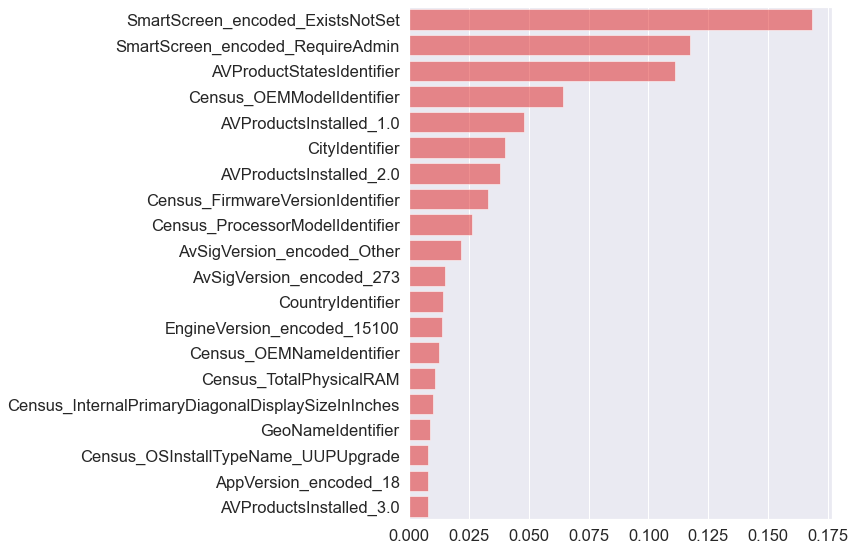

In [50]:
# Plot Feature Importances
plt.figure(figsize=(12, 8))
sns.barplot(y=feature_importance.index[:20], 
            x=feature_importance.values[:20],
            color='red',
            alpha=.5,
            orient='h')
plt.tight_layout()

## LightGBM

In [51]:
# Define model
lgbm_clf = LGBMClassifier(objective='binary', 
                          random_state = 42)

In [52]:
# Make pipeline with preprocessing, feature selection and model
pipeline_lgbm = Pipeline(steps=[('preprocessor', preprocessor),
                                ('filter', var_filter),
                                ('selector', selector),
                                ('classifier', lgbm_clf)
                               ])

In [53]:
# Randomized search
parameters ={'selector__k': [100, 200, 300],
             'preprocessor__num__strategy': ['median'],
             'preprocessor__bin__strategy': ['most_frequent'],
             'preprocessor__id__encoding__smoothing': [0.0, 10.0, 100.0],
             'preprocessor__cat__imputer__strategy': ['most_frequent', 'constant'],
             'classifier__learning_rate': [0.1, 0.3, 0.5],
             'classifier__max_depth': [-1, 3, 5, 10, 15],
             'classifier__bagging_fraction': [0.7, 1.0],
             'classifier__num_leaves': range(20,60,10),
             'classifier__n_estimators': [100, 200, 300]}

search_lgbm = RandomizedSearchCV(estimator=pipeline_lgbm, 
                                 param_distributions=parameters,
                                 n_iter=15,
                                 cv=3,
                                 scoring='roc_auc',
                                 return_train_score=True,
                                 verbose=3)

# Preprocessing of training data, fit model 
search_lgbm.fit(X_train, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 1/3] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=200, classifier__num_leaves=20, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__id__encoding__smoothing=0.0, preprocessor__num__strategy=median, selector__k=300;, score=(train=0.735, test=0.702) total time= 3.4min
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 2/3] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=200, classifier__num_leaves=20, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__id__encoding__smoothing=0.0, prep

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 2/3] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=3, classifier__n_estimators=100, classifier__num_leaves=30, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__id__encoding__smoothing=100.0, preprocessor__num__strategy=median, selector__k=100;, score=(train=0.728, test=0.699) total time= 2.9min
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[CV 3/3] END classifier__bagging_fraction=1.0, classifier__learning_rate=0.3, classifier__max_depth=3, classifier__n_estimators=100, classifier__num_leaves=30, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__id__encoding__smoothing=100.0, preprocessor__num__strategy=median, selector__k=100;, score=(

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 3/3] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=300, classifier__num_leaves=40, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__id__encoding__smoothing=0.0, preprocessor__num__strategy=median, selector__k=100;, score=(train=0.744, test=0.711) total time= 3.8min
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[CV 1/3] END classifier__bagging_fraction=0.7, classifier__learning_rate=0.5, classifier__max_depth=15, classifier__n_estimators=200, classifier__num_leaves=20, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=constant, preprocessor__id__encoding__smoothing=100.0, preprocessor__num__strategy=median, selector__k=100;, score=(train

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               SimpleImputer(),
                                                                               ['Census_ProcessorCoreCount',
                                                                                'Census_PrimaryDiskTotalCapacity',
                                                                                'Census_SystemVolumeTotalCapacity',
                                                                                'Census_TotalPhysicalRAM',
                                                                                'Census_InternalPrimaryDiagonalDisplaySizeInInches',
                                                                                'Census_InternalPrimaryDisplayResolutionHorizontal',
                                                                                '...
                                        'classifier__n_estimators': [100, 200,
                                                                     300],
                                        'classifier__num_leaves': range(20, 60, 10),
                                        'preprocessor__bin__strategy': ['most_frequent'],
                                        'preprocessor__cat__imputer__strategy': ['most_frequent',
                                                                                 'constant'],
                                        'preprocessor__id__encoding__smoothing': [0.0,
                                                                                  10.0,
                                                                                  100.0],
                                        'preprocessor__num__strategy': ['median'],
                                        'selector__k': [100, 200, 300]},
                   return_train_score=True, scoring='roc_auc', verbose=3)

In [54]:
# optimized model
opt_lgbm_clf = search_lgbm.best_estimator_
search_lgbm.best_params_

{'selector__k': 200,
 'preprocessor__num__strategy': 'median',
 'preprocessor__id__encoding__smoothing': 100.0,
 'preprocessor__cat__imputer__strategy': 'most_frequent',
 'preprocessor__bin__strategy': 'most_frequent',
 'classifier__num_leaves': 50,
 'classifier__n_estimators': 300,
 'classifier__max_depth': 5,
 'classifier__learning_rate': 0.5,
 'classifier__bagging_fraction': 0.7}

In [55]:
# Predictions
y_pred_train_lgbm = opt_lgbm_clf.predict(X_train)
y_pred_test_lgbm = opt_lgbm_clf.predict(X_test)
y_pred_proba_train_lgbm = opt_lgbm_clf.predict_proba(X_train)
y_pred_proba_test_lgbm = opt_lgbm_clf.predict_proba(X_test)

In [56]:
# ROC_AUC evaluation
roc_auc_train_lgbm = round(roc_auc_score(y_train, y_pred_proba_train_lgbm[:, 1]), 2)
roc_auc_test_lgbm = round(roc_auc_score(y_test, y_pred_proba_test_lgbm[:, 1]), 2)
print('Train Set roc auc:', roc_auc_train_lgbm) 
print('Test Set roc auc:', roc_auc_test_lgbm)

Train Set roc auc: 0.75
Test Set roc auc: 0.72


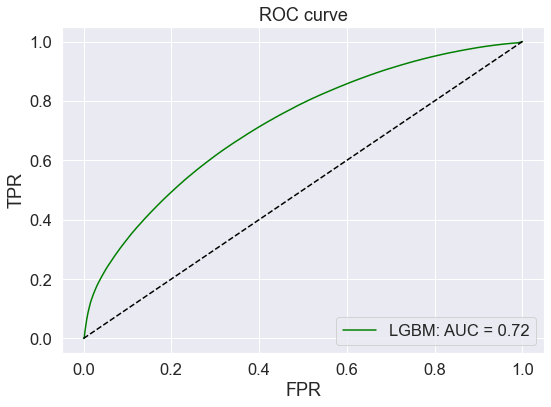

In [57]:
# plot ROC_AUC
fpr_lgbm, tpr_lgbm, thresholds_lgbm = metrics.roc_curve(y_test, y_pred_proba_test_lgbm[:,1])

plt.figure(figsize=(8,6))
plt.plot(fpr_lgbm, tpr_lgbm, color='green', label='LGBM: AUC = {}'.format(roc_auc_test_lgbm))
plt.plot([0,1], [0,1], '--', color = 'black')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc=4)
plt.title('ROC curve')
plt.tight_layout()

In [58]:
# classification report
print(classification_report(y_test, y_pred_test_lgbm))

              precision    recall  f1-score   support

           0       0.66      0.66      0.66    892394
           1       0.66      0.66      0.66    891902

    accuracy                           0.66   1784296
   macro avg       0.66      0.66      0.66   1784296
weighted avg       0.66      0.66      0.66   1784296



### LGBM Feature importance

In [59]:
search_lgbm.best_params_

{'selector__k': 200,
 'preprocessor__num__strategy': 'median',
 'preprocessor__id__encoding__smoothing': 100.0,
 'preprocessor__cat__imputer__strategy': 'most_frequent',
 'preprocessor__bin__strategy': 'most_frequent',
 'classifier__num_leaves': 50,
 'classifier__n_estimators': 300,
 'classifier__max_depth': 5,
 'classifier__learning_rate': 0.5,
 'classifier__bagging_fraction': 0.7}

In [60]:
# Preprocess data with best parameters
numerical_transformer_rev = SimpleImputer(strategy=search_lgbm.best_params_['preprocessor__num__strategy'])
binary_transformer_rev = SimpleImputer(strategy=search_lgbm.best_params_['preprocessor__bin__strategy'])
id_transformer_rev = Pipeline(steps=[
    ('encoding', TargetEncoder(search_lgbm.best_params_['preprocessor__id__encoding__smoothing']))
])
categorical_transformer_rev = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy=search_lgbm.best_params_['preprocessor__cat__imputer__strategy'])),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_rev = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_rev, num_col),
        ('bin', binary_transformer_rev, binary_col),
        ('id', id_transformer_rev, id_col),
        ('cat', categorical_transformer_rev, cat_col)
    ])

pipeline_rev = Pipeline(steps=[('preprocessor', preprocessor_rev)])

In [61]:
# Features Selected
chosen_feat = opt_lgbm_clf.named_steps['selector'].get_support()
list(enumerate(chosen_feat))

[(0, True),
 (1, True),
 (2, True),
 (3, True),
 (4, True),
 (5, True),
 (6, True),
 (7, True),
 (8, True),
 (9, False),
 (10, True),
 (11, False),
 (12, True),
 (13, False),
 (14, False),
 (15, False),
 (16, True),
 (17, True),
 (18, True),
 (19, True),
 (20, True),
 (21, True),
 (22, True),
 (23, True),
 (24, True),
 (25, True),
 (26, True),
 (27, True),
 (28, True),
 (29, True),
 (30, True),
 (31, True),
 (32, True),
 (33, True),
 (34, True),
 (35, True),
 (36, True),
 (37, False),
 (38, False),
 (39, False),
 (40, False),
 (41, False),
 (42, False),
 (43, True),
 (44, False),
 (45, True),
 (46, False),
 (47, True),
 (48, True),
 (49, True),
 (50, False),
 (51, True),
 (52, True),
 (53, True),
 (54, True),
 (55, False),
 (56, False),
 (57, False),
 (58, True),
 (59, True),
 (60, True),
 (61, True),
 (62, False),
 (63, False),
 (64, False),
 (65, True),
 (66, False),
 (67, False),
 (68, True),
 (69, True),
 (70, True),
 (71, False),
 (72, True),
 (73, True),
 (74, True),
 (75, True),

In [63]:
# Preprocess data with best parameters, get feature importances
X_values = preprocessor_rev.fit_transform(X_train, y_train)
onehot_col = pipeline_rev.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names(input_features=cat_col)
columns_tot = num_col + binary_col + id_col + onehot_col.tolist()
columns_tot = [feat for bool_, feat in zip(chosen_feat, columns_tot) if bool_]

feature_importance = pd.Series(data=opt_lgbm_clf.named_steps['classifier'].feature_importances_,
                               index = np.array(columns_tot))
feature_importance = feature_importance.sort_values(ascending=False)

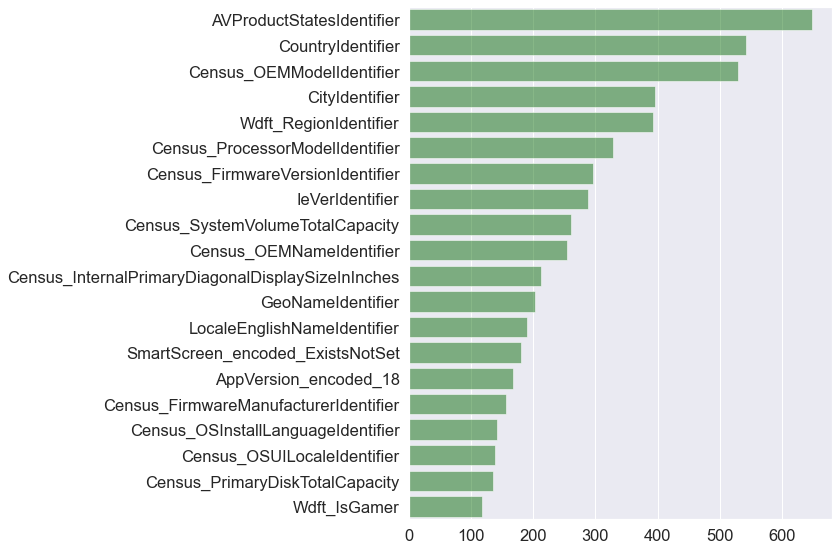

In [64]:
# Plot Feature Importances
plt.figure(figsize=(12, 8))
sns.barplot(y=feature_importance.index[:20], 
            x=feature_importance.values[:20],
            color='green',
            alpha=.5,
            orient='h')
plt.tight_layout()

## Logistic Regression

In [65]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', RobustScaler())
]) 

# Preprocessing for binary data
binary_transformer = SimpleImputer()

# Preprocessing for categorical data encoded as numerical ID's
id_transformer = Pipeline(steps=[
    ('encoding', TargetEncoder())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_col),
        ('bin', binary_transformer, binary_col),
        ('id', id_transformer, id_col),
        ('cat', categorical_transformer, cat_col)
    ])

In [66]:
# Define model
lr_clf = LogisticRegression(solver='saga', 
                            penalty='l1', 
                            random_state=42)

In [67]:
# Make pipeline with preprocessing, feature selection and model
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                              ('filter', VarianceThreshold(.001)),
                              ('classifier', lr_clf)
                             ])

In [68]:
# Grid search
parameters ={'preprocessor__num__imputer__strategy': ['median'],
             'preprocessor__bin__strategy': ['most_frequent'],
             'preprocessor__cat__imputer__strategy': ['most_frequent'],
             'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]}

search_lr = GridSearchCV(estimator=pipeline_lr, 
                         param_grid=parameters,
                         cv=3,
                         scoring='roc_auc',
                         return_train_score=True,
                         verbose=3)

# Preprocessing of training data, fit model 
search_lr.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END classifier__C=0.001, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__imputer__strategy=median;, score=(train=0.722, test=0.693) total time=17.1min
[CV 2/3] END classifier__C=0.001, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__imputer__strategy=median;, score=(train=0.722, test=0.693) total time=17.1min
[CV 3/3] END classifier__C=0.001, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__imputer__strategy=median;, score=(train=0.722, test=0.693) total time=16.9min
[CV 1/3] END classifier__C=0.01, preprocessor__bin__strategy=most_frequent, preprocessor__cat__imputer__strategy=most_frequent, preprocessor__num__imputer__strategy=median;, score=(train=0.724, test=0.694) total time=19.5min
[CV 2/3] END classifier__C=0.01, prep

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          RobustScaler())]),
                                                                         ['Census_ProcessorCoreCount',
                                                                          'Census_PrimaryDiskTotalCapacity',
                                                                          'Census_SystemVolumeTotalCapacity',
                                                                          'Census_TotalPhysicalRAM',
                                                                          'Census_InternalPrimaryDiagonalDisplaySizeInInches',
                                                                          'Ce...
                                        VarianceThreshold(threshold=0.001)),
                                       ('classifier',
                                        LogisticRegression(penalty='l1',
                                                           random_state=42,
                                                           solver='saga'))]),
             param_grid={'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'preprocessor__bin__strategy': ['most_frequent'],
                         'preprocessor__cat__imputer__strategy': ['most_frequent'],
                         'preprocessor__num__imputer__strategy': ['median']},
             return_train_score=True, scoring='roc_auc', verbose=3)

In [69]:
# optimized model
opt_lr_clf = search_lr.best_estimator_
search_lr.best_params_

{'classifier__C': 100,
 'preprocessor__bin__strategy': 'most_frequent',
 'preprocessor__cat__imputer__strategy': 'most_frequent',
 'preprocessor__num__imputer__strategy': 'median'}

In [71]:
# Predictions
y_pred_train_lr = opt_lr_clf.predict(X_train)
y_pred_test_lr = opt_lr_clf.predict(X_test)
y_pred_proba_train_lr = opt_lr_clf.predict_proba(X_train)
y_pred_proba_test_lr = opt_lr_clf.predict_proba(X_test)

In [72]:
# ROC_AUC evaluation
roc_auc_train_lr = round(roc_auc_score(y_train, y_pred_proba_train_lr[:, 1]), 2)
roc_auc_test_lr = round(roc_auc_score(y_test, y_pred_proba_test_lr[:, 1]), 2)
print('Train Set roc auc:', roc_auc_train_lr) 
print('Test Set roc auc:', roc_auc_test_lr)

Train Set roc auc: 0.72
Test Set roc auc: 0.7


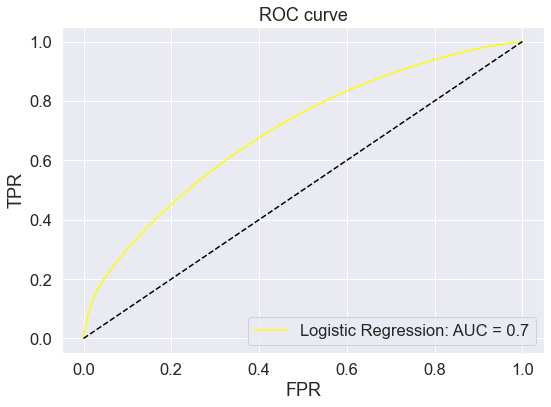

In [73]:
# plot ROC_AUC
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(y_test, y_pred_proba_test_lr[:,1])

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, color='yellow', label='Logistic Regression: AUC = {}'.format(roc_auc_test_lr))
plt.plot([0,1], [0,1], '--', color = 'black')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc=4)
plt.title('ROC curve')
plt.tight_layout()

In [74]:
# classification report
print(classification_report(y_test, y_pred_test_lr))

              precision    recall  f1-score   support

           0       0.64      0.63      0.63    892394
           1       0.64      0.65      0.64    891902

    accuracy                           0.64   1784296
   macro avg       0.64      0.64      0.64   1784296
weighted avg       0.64      0.64      0.64   1784296



## Stacking

In [75]:
estimators = [
    ('xgb', opt_xgb_clf),
    ('rf', opt_rf_clf),
    ('lgbm', opt_lgbm_clf),
    ('lr', opt_lr_clf)
]

In [76]:
stk_lr_clf = StackingClassifier(
    estimators=estimators, 
    final_estimator=LogisticRegression(),
    cv=3,
    verbose=3
)

In [77]:
stk_lr_clf.fit(X_train, y_train)

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 76.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 151.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 227.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 113.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 227.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 339.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.6min remaining:    0.0s


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  7.3min remaining:    0.0s


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 22.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 44.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 66.2min finished


StackingClassifier(cv=3,
                   estimators=[('xgb',
                                Pipeline(steps=[('preprocessor',
                                                 ColumnTransformer(transformers=[('num',
                                                                                  SimpleImputer(strategy='median'),
                                                                                  ['Census_ProcessorCoreCount',
                                                                                   'Census_PrimaryDiskTotalCapacity',
                                                                                   'Census_SystemVolumeTotalCapacity',
                                                                                   'Census_TotalPhysicalRAM',
                                                                                   'Census_InternalPrimaryDiagonalDisplaySizeInInches',
                                                                                   'Census_InternalPrimaryDisp...
                                                                                   'Census_OSWUAutoUpdateOptionsName',
                                                                                   'Census_GenuineStateName',
                                                                                   'Census_ActivationChannel',
                                                                                   'Census_FlightRing',
                                                                                   'Census_OSBranch_release_encoded',
                                                                                   'AvSigVersion_encoded', ...])])),
                                                ('filter',
                                                 VarianceThreshold(threshold=0.001)),
                                                ('classifier',
                                                 LogisticRegression(C=100,
                                                                    penalty='l1',
                                                                    random_state=42,
                                                                    solver='saga'))]))],
                   final_estimator=LogisticRegression(), verbose=3)

In [78]:
# Predictions
y_pred_train_stk = stk_lr_clf.predict(X_train)
y_pred_test_stk = stk_lr_clf.predict(X_test)
y_pred_proba_train_stk = stk_lr_clf.predict_proba(X_train)
y_pred_proba_test_stk = stk_lr_clf.predict_proba(X_test)

# ROC_AUC evaluation
roc_auc_train_stk = round(roc_auc_score(y_train, y_pred_proba_train_stk[:, 1]), 2)
roc_auc_test_stk = round(roc_auc_score(y_test, y_pred_proba_test_stk[:, 1]), 2)
print('Train Set roc auc:', roc_auc_train_stk) 
print('Test Set roc auc:', roc_auc_test_stk)

Train Set roc auc: 0.76
Test Set roc auc: 0.73


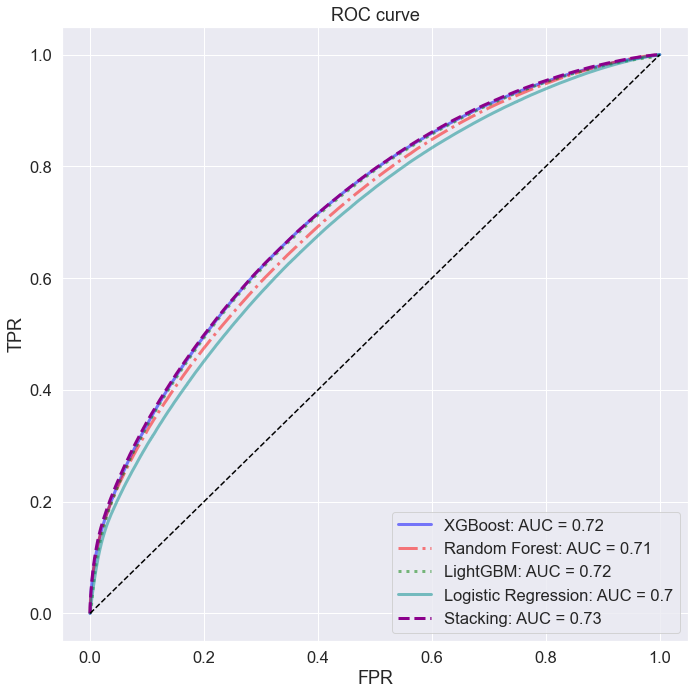

In [165]:
# plot ROC_AUC
fpr_stk, tpr_stk, thresholds_stk = metrics.roc_curve(y_test, y_pred_proba_test_stk[:,1])

plt.figure(figsize=(10,10))
plt.plot(fpr_xgb, tpr_xgb, color='blue', linestyle='-', linewidth=3, alpha=.5, label='XGBoost: AUC = {}'.format(roc_auc_test_xgb))
plt.plot(fpr_rf, tpr_rf, color='red', linestyle='-.', linewidth=3, alpha=.5, label='Random Forest: AUC = {}'.format(roc_auc_test_rf))
plt.plot(fpr_lgbm, tpr_lgbm, color='green', linestyle=':', linewidth=3, alpha=.5, label='LightGBM: AUC = {}'.format(roc_auc_test_lgbm))
plt.plot(fpr_lr, tpr_lr, color='darkcyan', linestyle='-', linewidth=3, alpha=.5, label='Logistic Regression: AUC = {}'.format(roc_auc_test_lr))
plt.plot(fpr_stk, tpr_stk, color='darkmagenta', linestyle='--', linewidth=3, label='Stacking: AUC = {}'.format(roc_auc_test_stk))

plt.plot([0,1], [0,1], '--', color = 'black')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc=4)
plt.title('ROC curve')
plt.tight_layout()

In [166]:
# classification report
print(classification_report(y_test, y_pred_test_stk))

              precision    recall  f1-score   support

           0       0.66      0.66      0.66    892394
           1       0.66      0.66      0.66    891902

    accuracy                           0.66   1784296
   macro avg       0.66      0.66      0.66   1784296
weighted avg       0.66      0.66      0.66   1784296



In [167]:
estimators = ['XGBoost', 'Random Forest', 'LightGBM', 'Logistic Regression']
coeff_df = pd.DataFrame({'Model':estimators, 'Coefficient':stk_lr_clf.final_estimator_.coef_.tolist()[0]})
coeff_df.set_index('Model')

,Coefficient
Model,
XGBoost,2.169014
Random Forest,3.303607
LightGBM,1.313139
Logistic Regression,-1.748189


In [168]:
# Save models in pickle format
with open('../models/optimized_XGB.pickle', 'wb') as handle:
    pickle.dump(opt_xgb_clf, handle)
    
with open('../models/optimized_RF.pickle', 'wb') as handle:
    pickle.dump(opt_rf_clf, handle)
    
with open('../models/optimized_LGBM.pickle', 'wb') as handle:
    pickle.dump(opt_lgbm_clf, handle)
    
with open('../models/optimized_LR.pickle', 'wb') as handle:
    pickle.dump(opt_lr_clf, handle)

with open('../models/stacking.pickle', 'wb') as handle:
    pickle.dump(stk_lr_clf, handle)